In [25]:
# Bloque 1: Importar librerías
import yfinance as yf
import pandas as pd
import ta
import numpy as np

In [26]:
# Función optimizada para obtener datos
def get_stock_data(ticker, period, interval):
    data = yf.download(ticker, period=period, interval=interval)
    data.columns = data.columns.droplevel(1)
    data.reset_index(inplace=True)
    data.rename(columns={"Datetime": "Date"}, inplace=True)

    # Convertir y extraer características de fecha
    data["Date"] = pd.to_datetime(data["Date"])
    data["Day"] = data["Date"].dt.day
    data["Month"] = data["Date"].dt.month
    data["Hour"] = data["Date"].dt.hour
    data["Year"] = data["Date"].dt.year
    data["Dia_de_la_Semana"] = data["Date"].dt.weekday
    data["Dia_del_Año"] = data["Date"].dt.dayofyear

    # Asignar 1 si el cierre es mayor que la apertura (verde), 0 si es menor o igual (rojo)
    data["Volumen_Color_Num"] = (data["Close"] > data["Open"]).astype(int)

    # Definir el tamaño de la ventana (aproximadamente 33 datos por semana)
    ventana_semanal = 70

    # Calcular el porcentaje de velas verdes en la última semana
    data["Porcentaje_Velas_Verdes"] = (
        data["Volumen_Color_Num"].rolling(window=ventana_semanal, min_periods=1).mean()
    )

    # Asignar categorías
    data["Tendencia_Semanal"] = 1  # Neutral por defecto
    data.loc[data["Porcentaje_Velas_Verdes"] > 0.65, "Tendencia_Semanal"] = 2  # Alcista
    data.loc[data["Porcentaje_Velas_Verdes"] < 0.35, "Tendencia_Semanal"] = 0  # Bajista

    return data

In [27]:
ticker = "GOOG"
period = "730d"  # Últimos 60 días
interval = "1h"  # Datos por hora

data_2w = get_stock_data(ticker, period, interval)

data_2w.head(-1)

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume,Day,Month,Hour,Year,Dia_de_la_Semana,Dia_del_Año,Volumen_Color_Num,Porcentaje_Velas_Verdes,Tendencia_Semanal
0,2022-04-29 13:30:00+00:00,117.468002,118.959999,117.046585,117.578003,343581,29,4,13,2022,4,119,0,0.000000,0
1,2022-04-29 14:30:00+00:00,117.545494,117.922134,117.027000,117.469994,160747,29,4,14,2022,4,119,1,0.500000,1
2,2022-04-29 15:30:00+00:00,117.297501,118.172997,117.000000,117.580505,107037,29,4,15,2022,4,119,0,0.333333,0
3,2022-04-29 16:30:00+00:00,117.561501,117.882492,116.991501,117.318748,116611,29,4,16,2022,4,119,1,0.500000,1
4,2022-04-29 17:30:00+00:00,116.558998,117.758560,116.459000,117.596497,99406,29,4,17,2022,4,119,0,0.400000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5080,2025-03-27 14:30:00+00:00,165.800003,166.600006,165.730103,166.399994,3060445,27,3,14,2025,3,86,0,0.542857,1
5081,2025-03-27 15:30:00+00:00,165.490005,166.160004,165.199997,165.820007,1938127,27,3,15,2025,3,86,0,0.542857,1
5082,2025-03-27 16:30:00+00:00,164.934998,165.779999,164.886505,165.479996,1513714,27,3,16,2025,3,86,0,0.542857,1
5083,2025-03-27 17:30:00+00:00,164.570007,165.285599,164.452499,164.925003,1949796,27,3,17,2025,3,86,0,0.528571,1


In [28]:
def calculate_indicators(data):
    # ===================== 📌 MEDIAS MÓVILES =====================
    data["EMA12"] = data["Close"].ewm(span=12, adjust=False).mean()
    data["EMA26"] = data["Close"].ewm(span=26, adjust=False).mean()
    data["EMA50"] = data["Close"].ewm(span=50, adjust=False).mean()
    data["SMA50"] = data["Close"].rolling(window=50).mean()

    # ===================== 🔥 BOLLINGER BANDS =====================
    data["BB_upper"] = (
        data["Close"].rolling(window=20).mean()
        + 2 * data["Close"].rolling(window=20).std()
    )
    data["BB_lower"] = (
        data["Close"].rolling(window=20).mean()
        - 2 * data["Close"].rolling(window=20).std()
    )
    data["BBW"] = (data["BB_upper"] - data["BB_lower"]) / data["Close"]  # Ancho de BB

    # ===================== 📊 VOLUMEN =====================
    data["Volume_MA"] = data["Volume"].rolling(window=20).mean()
    data["Vol_Ratio_10h"] = data["Volume"] / data["Volume"].rolling(window=10).mean()

    # ===================== 🔄 CAMBIOS PORCENTUALES =====================
    data["Hourly_Return"] = data["Close"].pct_change() * 100
    data["Cumulative_Return"] = (
        data["Close"].pct_change(periods=5) * 100
    )  # Cambio acumulado en 5 horas

    # ===================== 📈 MACD =====================
    data["MACD"] = data["EMA12"] - data["EMA26"]
    data["MACD_Signal"] = data["MACD"].ewm(span=9, adjust=False).mean()

    # ===================== 📊 RSI =====================
    data["RSI"] = ta.momentum.rsi(data["Close"], window=14)

    # ===================== 📉 ATR =====================
    data["ATR"] = ta.volatility.average_true_range(
        data["High"], data["Low"], data["Close"], window=14
    )

    # ===================== 📊 ADX (Índice de Dirección Media) =====================
    data["ADX"] = ta.trend.adx(data["High"], data["Low"], data["Close"], window=14)

    # ===================== 🔄 ESTOCÁSTICO =====================
    data["Stoch_K"] = ta.momentum.stoch(
        data["High"], data["Low"], data["Close"], window=14, smooth_window=3
    )
    data["Stoch_D"] = ta.momentum.stoch_signal(
        data["High"], data["Low"], data["Close"], window=14, smooth_window=3
    )

    # ===================== 🔥 MOMENTUM =====================
    data["MOM"] = ta.momentum.roc(data["Close"], window=10)

    # ===================== 🔎 OBV (On-Balance Volume) =====================
    data["OBV"] = ta.volume.on_balance_volume(data["Close"], data["Volume"])

    # ===================== 💰 CMF (Chaikin Money Flow) =====================
    data["CMF"] = ta.volume.chaikin_money_flow(
        data["High"], data["Low"], data["Close"], data["Volume"], window=20
    )

    # Eliminar filas con NaN generadas por indicadores
    data.dropna(inplace=True)

    return data


# Aplicar la función al dataframe
data_2w = calculate_indicators(data_2w)

# Mostrar primeras filas con indicadores
print(data_2w.head())

Price                      Date       Close        High         Low  \
49    2022-05-10 13:30:00+00:00  115.528503  116.654007  114.711502   
50    2022-05-10 14:30:00+00:00  114.149498  115.839005  113.383286   
51    2022-05-10 15:30:00+00:00  114.696495  115.416000  114.100243   
52    2022-05-10 16:30:00+00:00  115.175003  115.247498  114.083107   
53    2022-05-10 17:30:00+00:00  115.853004  116.630455  115.076500   

Price        Open  Volume  Day  Month  Hour  Year  ...      MACD  MACD_Signal  \
49     116.040504  358187   10      5    13  2022  ... -0.876189    -0.782754   
50     115.571548  219563   10      5    14  2022  ... -0.860264    -0.798256   
51     114.144249  128639   10      5    15  2022  ... -0.794349    -0.797475   
52     114.650246  128668   10      5    16  2022  ... -0.695482    -0.777076   
53     115.162498  155186   10      5    17  2022  ... -0.556010    -0.732863   

Price        RSI       ATR        ADX    Stoch_K    Stoch_D       MOM     OBV  \
49   

In [29]:
# 📌 Asegurar que 'Date' sea de tipo datetime
data_2w["Date"] = pd.to_datetime(data_2w["Date"])

# 📌 Calcular el cambio de RSI en una semana
data_2w["RSI_change_1w"] = data_2w["RSI"] - data_2w["RSI"].shift(70)
data_2w["RSI_change_2w"] = data_2w["RSI"] - data_2w["RSI"].shift(140)
data_2w["ADX_change_1w"] = data_2w["ADX"] - data_2w["ADX"].shift(70)
data_2w["ADX_change_2w"] = data_2w["ADX"] - data_2w["ADX"].shift(140)
data_2w["Volume_MA_change_1w"] = data_2w["Volume_MA"] - data_2w["Volume_MA"].shift(70)

In [30]:
# ===================== 📌 CAMBIO PORCENTUAL PASADO =====================

data_2w["Past_Change_1d"] = (
    (data_2w["Close"] - data_2w["Close"].shift(7)) / data_2w["Close"].shift(7) * 100
)
data_2w["Past_Change_2d"] = (
    (data_2w["Close"] - data_2w["Close"].shift(14)) / data_2w["Close"].shift(14) * 100
)
data_2w["Past_Change_1w"] = (
    (data_2w["Close"] - data_2w["Close"].shift(35)) / data_2w["Close"].shift(35) * 100
)
data_2w["Past_Change_2w"] = (
    (data_2w["Close"] - data_2w["Close"].shift(70)) / data_2w["Close"].shift(70) * 100
)

data_2w["Past_Change_1m"] = (
    (data_2w["Close"] - data_2w["Close"].shift(140)) / data_2w["Close"].shift(140) * 100
)
data_2w["Past_Change_2m"] = (
    (data_2w["Close"] - data_2w["Close"].shift(280)) / data_2w["Close"].shift(280) * 100
)

# ===================== 📌 CAMBIO PORCENTUAL FUTURO (2 SEMANAS) =====================
data_2w["Future_Change_2w"] = (
    (data_2w["Close"].shift(-70) - data_2w["Close"]) / data_2w["Close"] * 100
)


# ===================== 📌 FUNCIÓN PARA CLASIFICAR CAMBIOS =====================
def classify_change(percentage, percentiles):
    if percentage <= percentiles[0]:
        return 0  # Venta Muy Fuerte
    elif percentage <= percentiles[1]:
        return 1  # Venta
    else:
        return 2


# ===================== 📌 CALCULAR PERCENTILES DINÁMICOS =====================
percentiles_1w = np.percentile(data_2w["Past_Change_1w"].dropna(), [25, 75])
percentiles_2w = np.percentile(data_2w["Past_Change_2w"].dropna(), [25, 75])
percentiles_future_2w = np.percentile(data_2w["Future_Change_2w"].dropna(), [25, 75])
percentiles_1m = np.percentile(data_2w["Past_Change_1m"].dropna(), [25, 75])
percentiles_2m = np.percentile(data_2w["Past_Change_2m"].dropna(), [25, 75])

# ===================== 📌 APLICAR CLASIFICACIÓN =====================
data_2w["Past_Class_1w"] = data_2w["Past_Change_1w"].apply(
    lambda x: classify_change(x, percentiles_1w)
)
data_2w["Past_Class_2w"] = data_2w["Past_Change_2w"].apply(
    lambda x: classify_change(x, percentiles_2w)
)
data_2w["Past_Class_1m"] = data_2w["Past_Change_1m"].apply(
    lambda x: classify_change(x, percentiles_1m)
)
data_2w["Past_Class_2m"] = data_2w["Past_Change_2m"].apply(
    lambda x: classify_change(x, percentiles_2m)
)

data_2w["Future_Class_2w"] = data_2w["Future_Change_2w"].apply(
    lambda x: classify_change(x, percentiles_future_2w)
)

data_2w["Volatility_Spike_VH"] = (
    data_2w["Past_Change_2w"] <= percentiles_2w[0]
).astype(int)
data_2w["Volatility_Spike_H"] = (data_2w["Past_Change_2w"] <= percentiles_2w[1]).astype(
    int
)
data_2w["Volatility_Spike_I"] = (data_2w["Past_Change_2w"] <= percentiles_2w[1]).astype(
    int
)

data_2w["Volatility_Spike_VH_m"] = (
    data_2w["Past_Change_2m"] <= percentiles_2m[0]
).astype(int)
data_2w["Volatility_Spike_H_m"] = (
    data_2w["Past_Change_2m"] <= percentiles_2m[1]
).astype(int)
data_2w["Volatility_Spike_I_m"] = (
    data_2w["Past_Change_2m"] <= percentiles_2m[1]
).astype(int)


# ===================== 📌 MOSTRAR RESULTADOS =====================
print("Percentiles de cambios pasados (2 semanas):", percentiles_2w)

Percentiles de cambios pasados (2 semanas): [-3.36226737  4.54631596]


In [31]:
def mark_previous_hours(data, column_name, percentiles, horas_a_marcar=84):
    # Crear las nuevas columnas e inicializarlas con 0
    data[f"previousd_strongsell"] = 0
    data[f"previousd_strongbuy"] = 0

    # Iterar sobre los datos para marcar las horas previas
    for i in range(
        horas_a_marcar, len(data)
    ):  # Comenzamos desde el índice de horas_a_marcar
        # Verificar si el cambio porcentual pasado cae por debajo del percentil 15 (fuerte caída)
        if data[column_name].iloc[i] <= percentiles[0]:
            # Marcar las horas previas como 1 en 'previousd_strongsell'
            data.loc[data.index[i - horas_a_marcar : i], "previousd_strongsell"] = 1

        # Verificar si el cambio porcentual pasado es mayor que el percentil 58 (subida moderada)
        if data[column_name].iloc[i] >= percentiles[1]:
            # Marcar las horas previas como 1 en 'previousd_buy'
            data.loc[data.index[i - horas_a_marcar : i], "previousd_strongbuy"] = 1

    # Devolver el DataFrame con las nuevas columnas
    return data


data_2w = mark_previous_hours(data_2w, "Past_Change_2w", percentiles_2w, 84)

In [32]:
data_2w["Tendencia_Semanal"].value_counts()

Tendencia_Semanal
1    5009
0      20
2       8
Name: count, dtype: int64

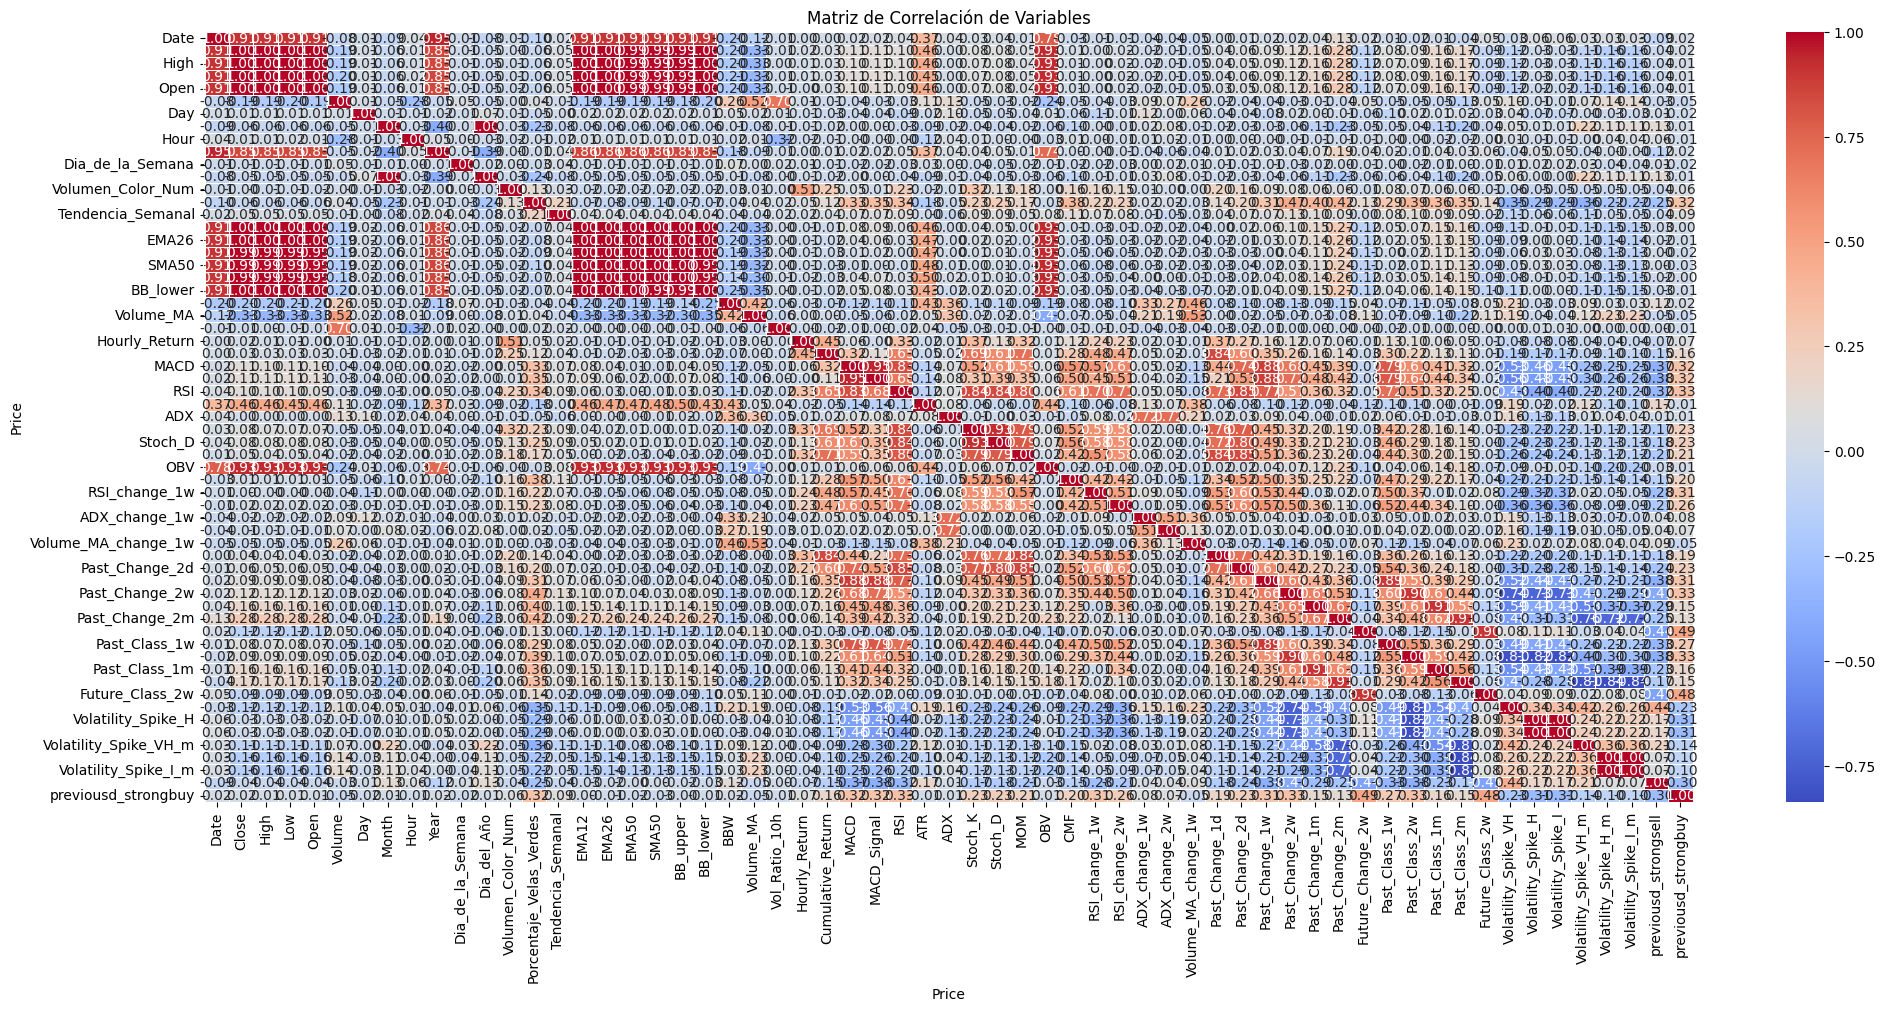

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = data_2w.corr()

# Configurar la figura
plt.figure(figsize=(24, 10))

# Crear un heatmap con Seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Título del gráfico
plt.title("Matriz de Correlación de Variables")

# Mostrar la gráfica
plt.show()

In [34]:
# 🔹 Obtener las variables con correlación débil con 'Future_Class_2w'
low_corr_features = correlation_matrix.index[
    correlation_matrix["Future_Class_2w"].between(-0.1, 0.1)
].difference(["Date", "Close"])

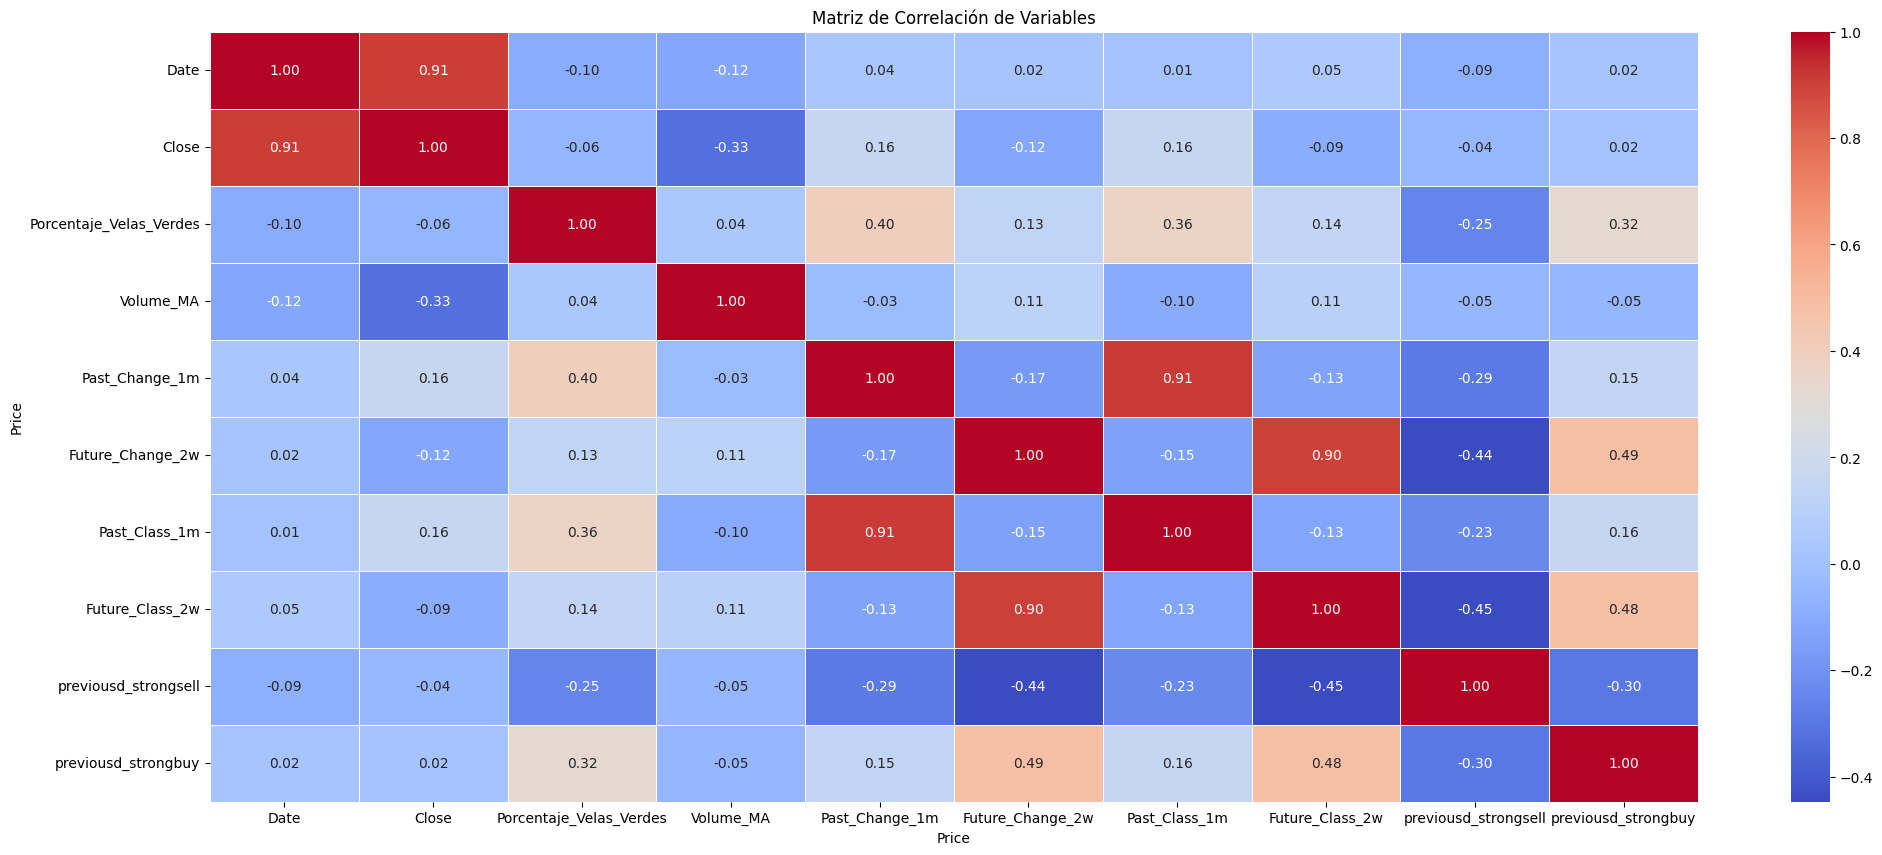

In [35]:
from sklearn.preprocessing import MinMaxScaler

# 📌 Eliminar las columnas con baja correlación
data_2w = data_2w.drop(columns=data_2w[low_corr_features])

correlation_matrix = data_2w.corr()

# Configurar la figura
plt.figure(figsize=(24, 10))

# Crear un heatmap con Seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Título del gráfico
plt.title("Matriz de Correlación de Variables")

# Mostrar la gráfica
plt.show()

In [36]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Eliminar valores nulos
data_train_2w = data_2w.dropna()

# Preparar los datos
X = data_train_2w.drop(columns=["Future_Change_2w", "Future_Class_2w", "Date"])
y = data_train_2w["Future_Class_2w"]

# Normalización de las características usando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled_2w = scaler.fit_transform(X)

# Definir la fecha de corte (por ejemplo, 2024-01-01)
fecha_corte = "2024-05-01"

# Crear el conjunto de entrenamiento (hasta la fecha de corte)
train_data = data_train_2w[data_train_2w["Date"] < fecha_corte]
test_data = data_train_2w[data_train_2w["Date"] >= fecha_corte]

# Preparar los datos de entrenamiento y prueba
X_train_2w = train_data.drop(columns=["Future_Change_2w", "Future_Class_2w", "Date"])
y_train_2w = train_data["Future_Class_2w"]
X_test_2w = test_data.drop(columns=["Future_Change_2w", "Future_Class_2w", "Date"])
y_test_2w = test_data["Future_Class_2w"]

# Inicializar los modelos
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1,
    ),
    "XGBoost": xgb.XGBClassifier(
        eval_metric="mlogloss",
        n_estimators=500,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        min_child_weight=5,
        random_state=42,
        n_jobs=-1,
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=6,
        min_samples_split=10,
        min_samples_leaf=5,
        subsample=0.8,
        random_state=42,
    ),
    "LightGBM": lgb.LGBMClassifier(
        objective="multiclass",
        num_class=5,
        n_estimators=500,
        learning_rate=0.01,
        max_depth=-1,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        force_col_wise=True,
        random_state=42,
        n_jobs=-1,
        verbose=-1,
    ),
}

# Entrenar y evaluar cada modelo
predictions_2w = {}
model_metrics = {}

for name, model in models.items():
    print(f"Entrenando modelo: {name}")

    # Entrenar el modelo con el conjunto de entrenamiento completo
    model.fit(X_train_2w, y_train_2w)

    # Hacer predicciones sobre el conjunto de prueba
    y_pred = model.predict(X_test_2w)

    # Guardar predicciones y métricas
    predictions_2w[name] = y_pred
    report_2w = classification_report(
        y_test_2w, y_pred, output_dict=True, zero_division=1
    )
    model_metrics[name] = report_2w

# Imprimir los resultados
for name, metrics in model_metrics.items():
    print(f"\nReporte de clasificación para el modelo: {name}")
    print(metrics)

Entrenando modelo: Random Forest
Entrenando modelo: XGBoost
Entrenando modelo: Gradient Boosting
Entrenando modelo: LightGBM

Reporte de clasificación para el modelo: Random Forest
{'0': {'precision': 0.703125, 'recall': 0.627906976744186, 'f1-score': 0.6633906633906634, 'support': 430.0}, '1': {'precision': 0.631496062992126, 'recall': 0.50125, 'f1-score': 0.5588850174216028, 'support': 800.0}, '2': {'precision': 0.3709016393442623, 'recall': 0.6534296028880866, 'f1-score': 0.47320261437908495, 'support': 277.0}, 'accuracy': 0.5653616456536165, 'macro avg': {'precision': 0.5685075674454628, 'recall': 0.5941955265440909, 'f1-score': 0.5651594317304505, 'support': 1507.0}, 'weighted avg': {'precision': 0.6040347408706446, 'recall': 0.5653616456536165, 'f1-score': 0.5729549591096709, 'support': 1507.0}}

Reporte de clasificación para el modelo: XGBoost
{'0': {'precision': 0.6622807017543859, 'recall': 0.7023255813953488, 'f1-score': 0.6817155756207675, 'support': 430.0}, '1': {'precision

In [37]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

# Evaluar modelos con Accuracy, F1-score y Kappa
model_scores_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    accuracy = accuracy_score(y_test_2w, y_pred_2w)
    f1 = f1_score(y_test_2w, y_pred_2w, average="weighted")  # F1 ponderado
    kappa = cohen_kappa_score(y_test_2w, y_pred_2w)  # Cohen's Kappa

    model_scores_2w[model_name] = {"accuracy": accuracy, "f1_score": f1, "kappa": kappa}

# Ordenar modelos por precisión (puedes cambiar a 'f1_score' o 'kappa' si prefieres)
sorted_models_2w = sorted(
    model_scores_2w.items(), key=lambda x: x[1]["accuracy"], reverse=True
)

# Imprimir los 3 mejores modelos
print("🔹 Top 3 Modelos Basados en Precisión:")
for i, (model_name, scores) in enumerate(sorted_models_2w[:3]):
    print(
        f"{i + 1}. {model_name} - Precisión: {scores['accuracy']:.4f} | F1-Score: {scores['f1_score']:.4f} | Kappa: {scores['kappa']:.4f}"
    )

🔹 Top 3 Modelos Basados en Precisión:
1. Random Forest - Precisión: 0.5654 | F1-Score: 0.5730 | Kappa: 0.3252
2. LightGBM - Precisión: 0.5528 | F1-Score: 0.5557 | Kappa: 0.3250
3. XGBoost - Precisión: 0.5501 | F1-Score: 0.5511 | Kappa: 0.3323


In [38]:
# Mostrar la cantidad de cada predicción por modelo
prediction_counts_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    unique, counts = np.unique(
        y_pred_2w, return_counts=True
    )  # Contar la frecuencia de cada predicción
    prediction_counts_2w[model_name] = dict(zip(unique, counts))

In [39]:
# Crear un DataFrame para almacenar las predicciones y los valores reales
comparison_df_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    # Crear un DataFrame con las predicciones y las clases reales
    comparison_df_2w[model_name] = pd.DataFrame(
        {
            "Real": y_test_2w,  # Valores reales
            "Predicción": y_pred_2w,  # Predicciones del modelo
        }
    )

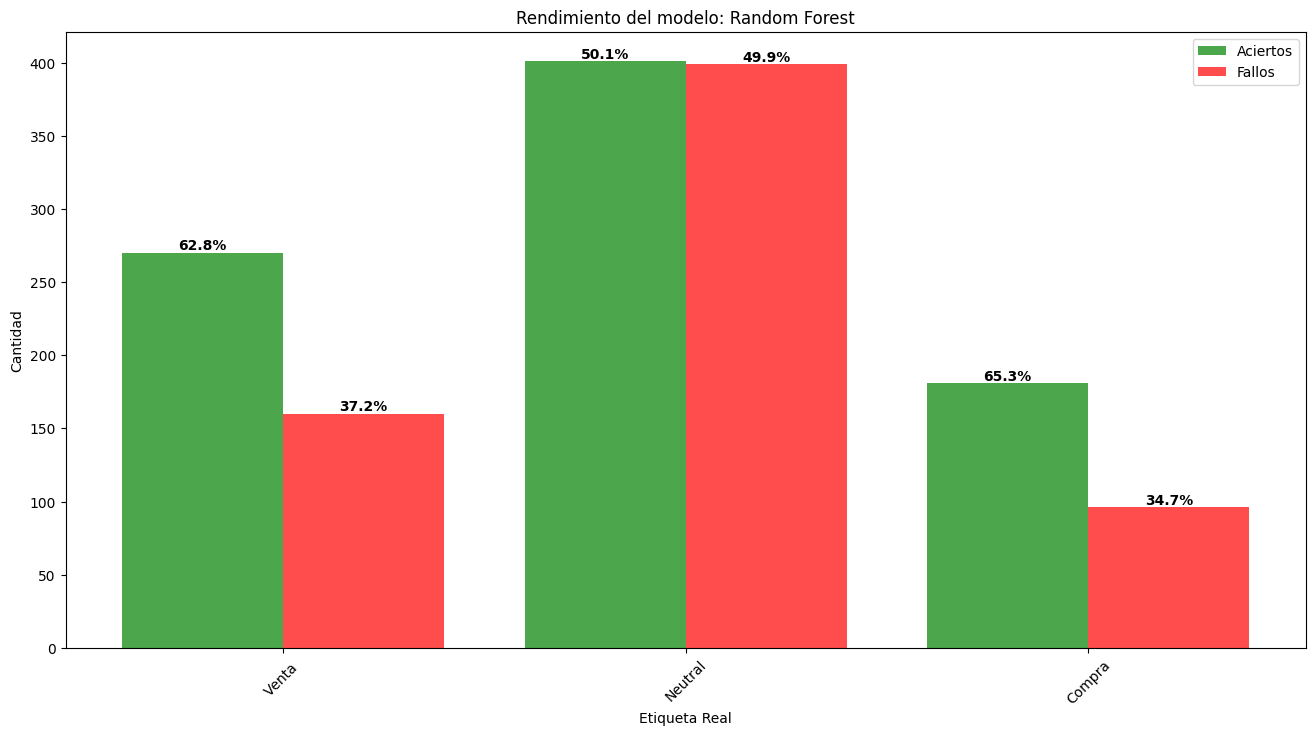

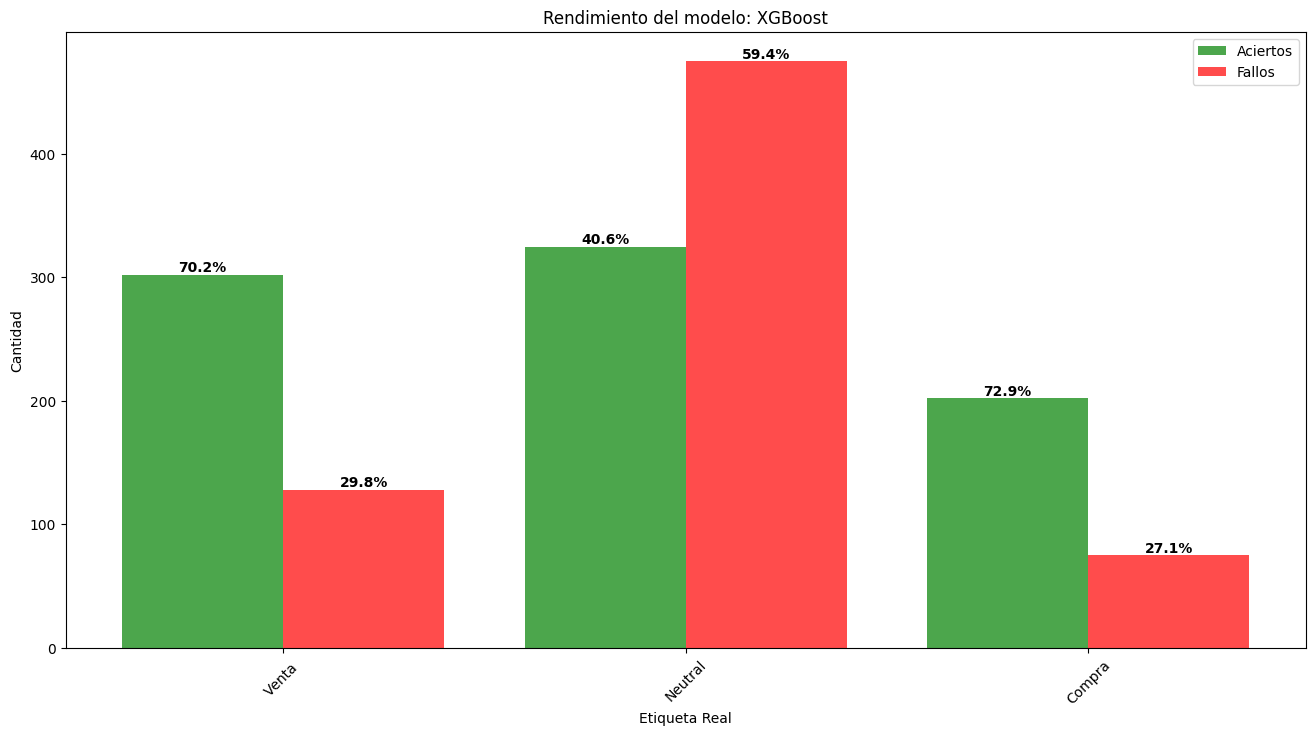

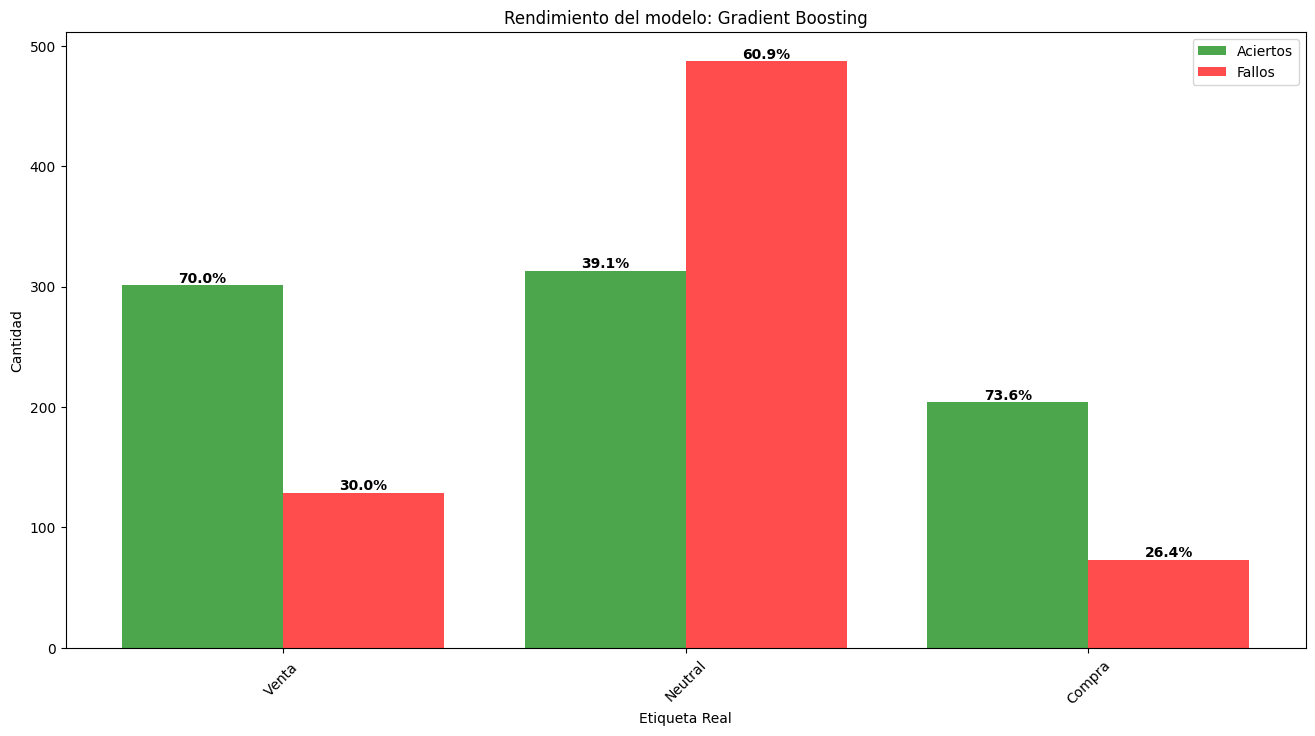

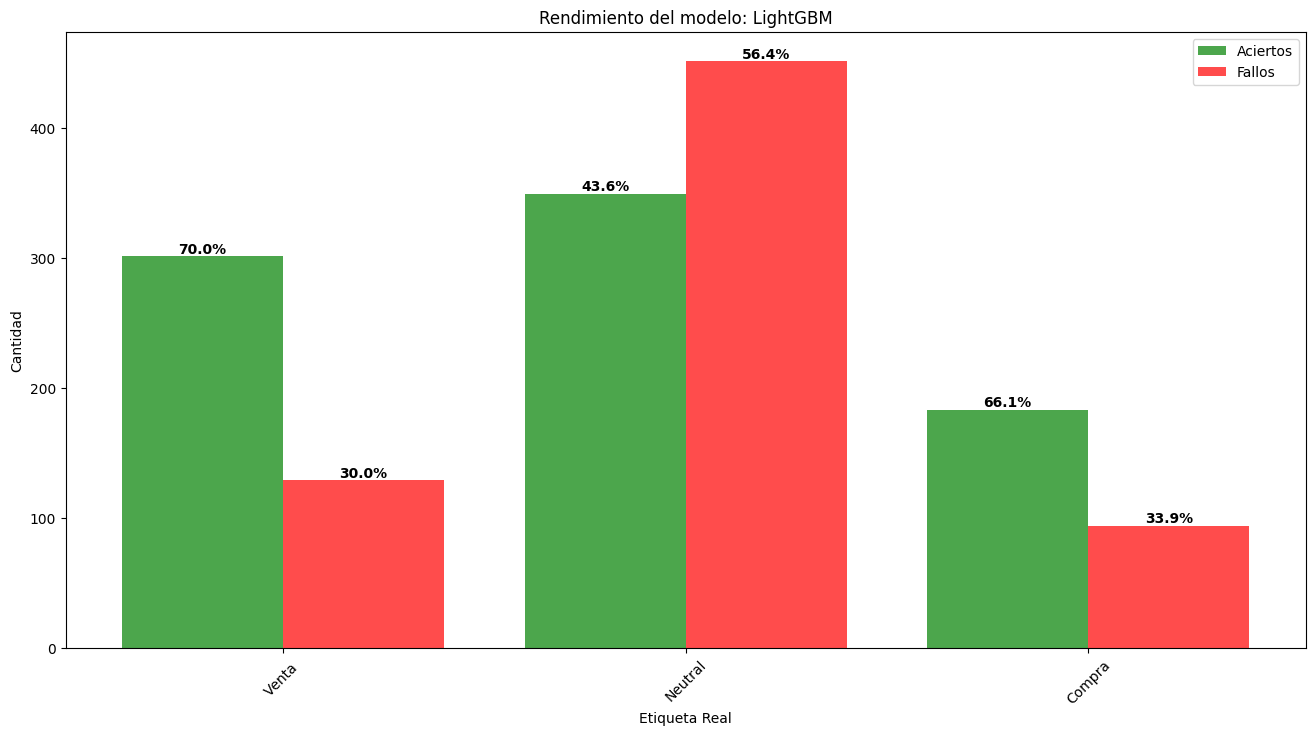

In [40]:
# 🔹 Diccionario para mapear números a etiquetas (con orden específico)
label_mapping = {
    0: "Venta ",
    1: "Neutral",
    2: "Compra",
}

# Lista ordenada de etiquetas
ordered_labels = list(label_mapping.values())

# 🔹 Crear un DataFrame para almacenar las comparaciones
comparison_df_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    # Crear DataFrame con valores reales y predicciones
    df = pd.DataFrame({"Real": y_test_2w, "Predicción": y_pred_2w})

    # Convertir los valores numéricos a etiquetas de texto
    df["Real"] = df["Real"].map(label_mapping)
    df["Predicción"] = df["Predicción"].map(label_mapping)

    # Definir el orden de las categorías para "Real" y "Predicción"
    df["Real"] = pd.Categorical(df["Real"], categories=ordered_labels, ordered=True)
    df["Predicción"] = pd.Categorical(
        df["Predicción"], categories=ordered_labels, ordered=True
    )

    # Guardar en el diccionario
    comparison_df_2w[model_name] = df

# 🔹 Crear una gráfica para comparar aciertos y errores por cada etiqueta
for model_name, df in comparison_df_2w.items():
    df["Correcto"] = df["Real"] == df["Predicción"]  # True si acertó, False si falló

    # Contar aciertos y errores por etiqueta
    results = (
        df.groupby(["Real", "Correcto"], observed=False).size().unstack(fill_value=0)
    )

    # Asegurar que las columnas existen y renombrarlas si es necesario
    results = results.rename(columns={True: "Aciertos", False: "Fallos"})

    # Si faltan columnas, agregarlas con 0
    results = results.reindex(columns=["Aciertos", "Fallos"], fill_value=0)

    # Calcular porcentajes
    total_counts = results.sum(axis=1)
    percentages = results.div(total_counts, axis=0) * 100  # Convertir a porcentaje

    # 🔹 Gráfica con barras separadas (verde a la izquierda, roja a la derecha)
    x = np.arange(len(ordered_labels))  # Posiciones de las etiquetas
    width = 0.4  # Ancho de las barras

    plt.figure(figsize=(16, 8))

    # Barras de aciertos (izquierda)
    bars1 = plt.bar(
        x - width / 2,
        results["Aciertos"],
        width=width,
        color="green",
        alpha=0.7,
        label="Aciertos",
    )

    # Barras de fallos (derecha)
    bars2 = plt.bar(
        x + width / 2,
        results["Fallos"],
        width=width,
        color="red",
        alpha=0.7,
        label="Fallos",
    )

    # 🔹 Añadir los porcentajes sobre cada barra
    for bar, pct1 in zip(bars1, percentages["Aciertos"]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{pct1:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    for bar, pct2 in zip(bars2, percentages["Fallos"]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{pct2:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # 🔹 Formato final de la gráfica
    plt.title(f"Rendimiento del modelo: {model_name}")
    plt.xlabel("Etiqueta Real")
    plt.ylabel("Cantidad")
    plt.xticks(x, ordered_labels, rotation=45)  # Etiquetas con rotación
    plt.legend()
    plt.show()

In [41]:
# Obtener los datos de ayer (última fila)
yesterday_data = data_2w.iloc[-1:]

# Extraer fecha y precio de cierre de ayer
yesterday_date = yesterday_data["Date"].values[0]
yesterday_close = yesterday_data["Close"].values[0]

# Asegurar que no incluimos variables de futuro
X_yesterday = yesterday_data.drop(
    columns=["Future_Change_2w", "Future_Class_2w", "Date"]
)
X_yesterday_np = (
    X_yesterday.to_numpy()
)  # Convertir a numpy para evitar warnings de Scikit-Learn

# Hacer predicciones con cada modelo
future_predictions = {}

for model_name, model in models.items():
    future_prediction = model.predict(X_yesterday_np)[
        0
    ]  # Obtener la predicción numérica

    future_predictions[model_name] = (
        f"📉 Caída (< {percentiles_future_2w[0]:.2f}%)"
        if future_prediction == 0
        else (
            f"➖  Sin cambios significativos ({percentiles_future_2w[0]:.2f}% a {percentiles_future_2w[1]:.2f}%)"
            if future_prediction == 1
            else (f"➖  Sin cambios significativos (>{percentiles_future_2w[1]:.2f}%)")
        )
    )

# Mostrar los resultados con fecha formateada correctamente
print(
    f"\n📅 Fecha de la última observación: {pd.to_datetime(yesterday_date).strftime('%Y-%m-%d %H:%M')}"
)
print(f"💰 Precio de cierre: {yesterday_close:.2f} USD\n")

print("🔮 Predicciones de 'Future_Class_2w' para los datos de ayer:")
for model_name, prediction in future_predictions.items():
    print(f"⚡ {model_name}: {prediction}")


📅 Fecha de la última observación: 2025-03-27 19:30
💰 Precio de cierre: 164.06 USD

🔮 Predicciones de 'Future_Class_2w' para los datos de ayer:
⚡ Random Forest: ➖  Sin cambios significativos (-3.36% a 4.55%)
⚡ XGBoost: ➖  Sin cambios significativos (-3.36% a 4.55%)
⚡ Gradient Boosting: ➖  Sin cambios significativos (-3.36% a 4.55%)
⚡ LightGBM: ➖  Sin cambios significativos (-3.36% a 4.55%)


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [42]:
import matplotlib.pyplot as plt

# Últimos 350 registros para graficar historial
data_last_350 = data_2w.tail(500)

# Obtener datos de ayer (última fila)
yesterday_data_2w = data_2w.iloc[-1:]
yesterday_date_2w = yesterday_data_2w["Date"].values[0]
yesterday_close_2w = yesterday_data_2w["Close"].values[0]

# Asegurar que no incluimos variables de futuro
X_yesterday_2w = yesterday_data.drop(
    columns=["Future_Change_2w", "Future_Class_2w", "Date"]
)
X_yesterday_2w_np = X_yesterday.to_numpy()

# Definir cuántos pasos futuros extenderemos la banda
future_steps_2w = 70
last_date = data_last_350["Date"].max()  # Última fecha en la data histórica
future_dates_2w = pd.date_range(start=last_date, periods=future_steps_2w + 1, freq="h")[
    1:
]

In [43]:
def check_prediction_for_specific_day(data, x, periods_ahead=70):
    """
    Verifica la predicción de los modelos para una fecha específica `x` períodos atrás
    y su resultado futuro en 'Future_Class_2w', mostrando ambos cierres.
    """
    # Verificar si hay suficientes datos hacia atrás
    if x >= len(data):
        print(f"⚠️ No hay suficientes datos para verificar {x} períodos atrás.")
        return

    # Obtener los datos de hace `x` períodos
    specific_day_data = data.iloc[-x]  # Últimos `x` períodos hacia atrás
    specific_date = specific_day_data["Date"]

    # Calcular la fecha futura correctamente
    future_index = -x + periods_ahead  # 70 períodos adelante (~2 semanas en 1h)

    if future_index < len(data):
        future_day_data = data.iloc[future_index]
        future_date = future_day_data["Date"]
        close_future = future_day_data["Close"]
    else:
        future_date = "N/A"
        close_future = None  # No hay suficiente data para ver el cierre futuro

    # Seleccionar características para el modelo (excluyendo la columna objetivo y la fecha)
    features = [
        col
        for col in data.columns
        if col not in ["Future_Change_2w", "Future_Class_2w", "Date"]
    ]
    X_specific_day = specific_day_data[features]

    # Realizar predicciones con cada modelo
    specific_day_predictions_2w = {}
    for model_name, model in models.items():
        future_prediction = model.predict([X_specific_day])
        specific_day_predictions_2w[model_name] = future_prediction[
            0
        ]  # Guardar la predicción

    # Obtener la clase real y el cambio futuro
    real_class_future = specific_day_data["Future_Class_2w"]
    real_change_future = specific_day_data["Future_Change_2w"]

    # Determinar en qué rango cae el cambio real según los percentiles
    real_class_from_change = (
        0
        if real_change_future <= percentiles_future_2w[0]
        else 1 if real_change_future <= percentiles_future_2w[1] else 2
    )

    # 📌 Mostrar resultados con fecha real y cierres
    print(f"\n📅 Fecha evaluada: {specific_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💰 Cierre en la fecha evaluada: {specific_day_data['Close']:.2f} USD")
    print(
        f"📅 Fecha futura (2 semanas después): {future_date if future_date != 'N/A' else 'No disponible'}"
    )

    if close_future is not None:
        print(f"💰 Cierre en la fecha futura: {close_future:.2f} USD")

    print(f"🔹 Clase real 'Future_Class_2w': {real_class_future}")
    print(
        f"🔹 Cambio real: {real_change_future:.2f}% -> Clasificado como {real_class_from_change}"
    )

    print(f"\n📊 Percentiles para clasificación:")
    for i, perc in enumerate(percentiles_future_2w):
        print(f"   🔹 Percentil {i}: {perc:.2f}%")

    print("\n🔍 Predicciones de los modelos:")
    for model_name, prediction in specific_day_predictions_2w.items():
        resultado = "✅ Acertó!" if prediction == real_class_future else "❌ No acertó."
        print(
            f"   {model_name}: Predicción = {prediction} | Real = {real_class_future} -> {resultado}"
        )

    # 🚀 Depuración si hay errores en la fecha futura
    if isinstance(future_date, str) or future_date.year < 2025:
        print("\n⚠️ Posible error en el cálculo de la fecha futura.")
        print(f"   Índice futuro esperado: {future_index}")
        print(f"   Fecha estimada en DataFrame: {future_date}")


# 🔹 **Ejemplo de uso:**
print(data_2w.shape)

check_prediction_for_specific_day(
    data_2w, x=71
)  # Verifica hace 100 períodos (~4-5 días hábiles en 1h)

(5037, 10)

📅 Fecha evaluada: 2025-03-13 19:30:00
💰 Cierre en la fecha evaluada: 164.75 USD
📅 Fecha futura (2 semanas después): 2025-03-27 19:30:00+00:00
💰 Cierre en la fecha futura: 164.06 USD
🔹 Clase real 'Future_Class_2w': 1
🔹 Cambio real: -0.42% -> Clasificado como 1

📊 Percentiles para clasificación:
   🔹 Percentil 0: -3.36%
   🔹 Percentil 1: 4.55%

🔍 Predicciones de los modelos:
   Random Forest: Predicción = 2 | Real = 1 -> ❌ No acertó.
   XGBoost: Predicción = 2 | Real = 1 -> ❌ No acertó.
   Gradient Boosting: Predicción = 2 | Real = 1 -> ❌ No acertó.
   LightGBM: Predicción = 2 | Real = 1 -> ❌ No acertó.


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(



📅 Fecha evaluada: 2025-03-13 15:30:00
💰 Cierre en la fecha evaluada: 165.08 USD
📅 Fecha futura (2 semanas después): 2025-03-27 15:30:00
💰 Cierre en la fecha futura: 165.49 USD
📈 Cambio real en porcentaje: 0.25%

🔍 Predicciones de los modelos y precios proyectados:
   Random Forest: Predicción = 2 | Rango esperado = 172.59 - 189.09 USD
   🎯 Rango de percentiles: 4.55% - 14.55% -> ❌ No acertó.
   XGBoost: Predicción = 2 | Rango esperado = 172.59 - 189.09 USD
   🎯 Rango de percentiles: 4.55% - 14.55% -> ❌ No acertó.
   Gradient Boosting: Predicción = 2 | Rango esperado = 172.59 - 189.09 USD
   🎯 Rango de percentiles: 4.55% - 14.55% -> ❌ No acertó.
   LightGBM: Predicción = 1 | Rango esperado = 159.53 - 172.59 USD
   🎯 Rango de percentiles: -3.36% - 4.55% -> ✅ Acertó!


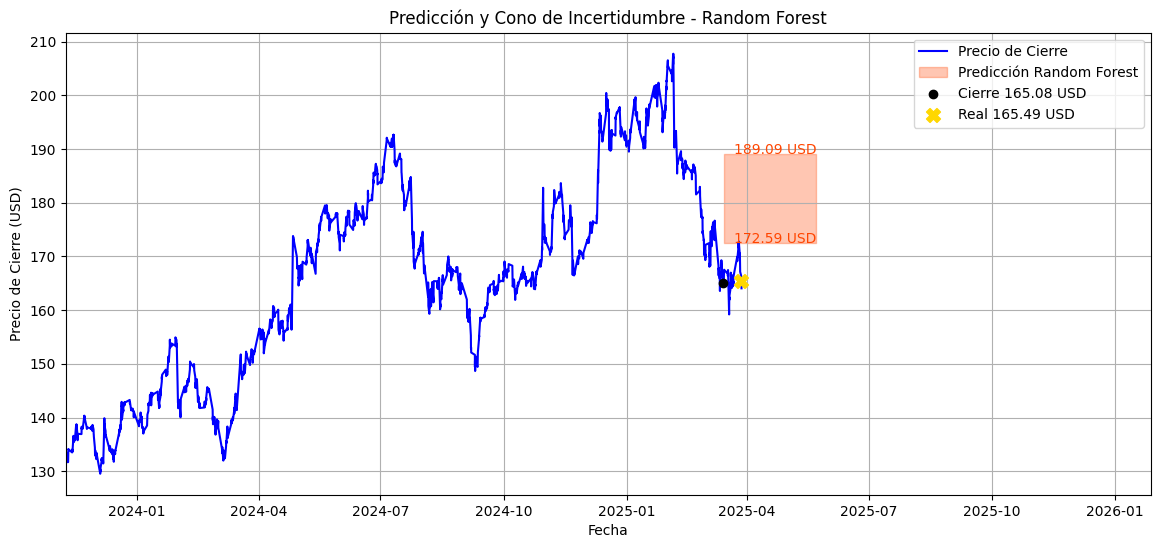

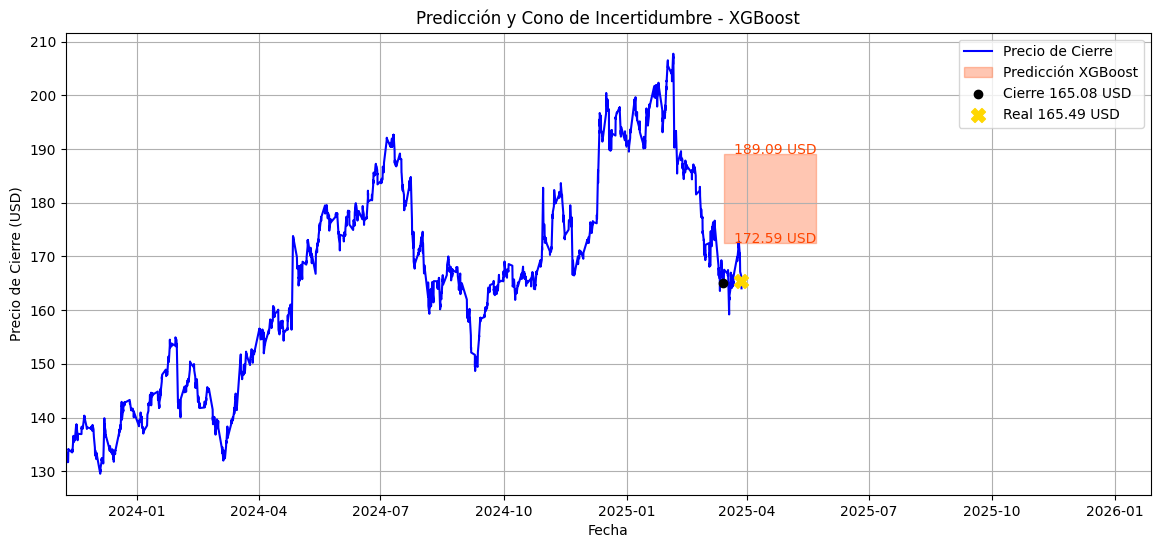

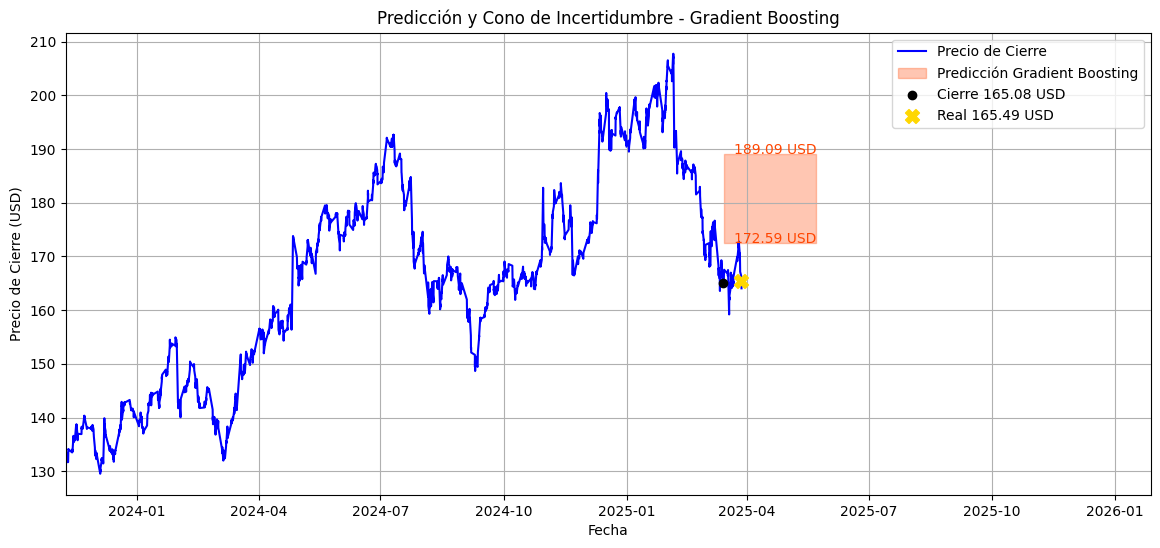

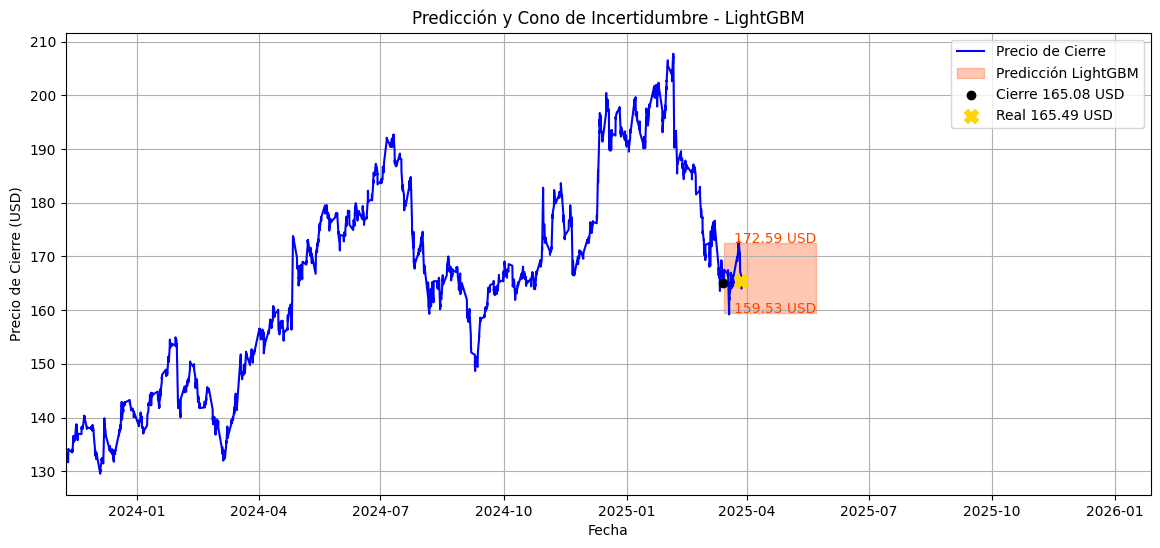

In [45]:
def check_prediction_with_cone(data, x, periods_ahead=70, num_days_to_plot=200):
    if -x >= len(data) or -x + periods_ahead >= len(data):
        print(f"⚠️ No hay suficientes datos para verificar {x} períodos atrás.")
        return

    # 🔹 Obtener datos del punto de partida
    specific_day_data = data.iloc[-x]
    specific_date = specific_day_data["Date"]
    close_actual = specific_day_data["Close"]

    # 🔹 Obtener datos del punto futuro donde se verificará la predicción
    future_day_data = data.iloc[-x + periods_ahead]
    future_date = future_day_data["Date"]
    close_future = future_day_data["Close"]

    # 🔹 Calcular el cambio real en porcentaje
    real_change_percent = ((close_future - close_actual) / close_actual) * 100

    # 🔹 Extraer características para la predicción
    features = [
        col
        for col in data.columns
        if col not in ["Future_Change_2w", "Future_Class_2w", "Date"]
    ]
    X_specific_day = specific_day_data[features]

    specific_day_predictions = {}
    projected_prices = {}

    for model_name, model in models.items():
        future_prediction = int(model.predict([X_specific_day])[0])
        specific_day_predictions[model_name] = future_prediction

        # 🔹 Determinar el rango según la predicción
        if future_prediction == 0:  # Caída muy fuerte
            color = "red"
            pred_range = (percentiles_future_2w[0] - 10, percentiles_future_2w[0])
        elif future_prediction == 1:  # Caída moderada
            color = "orangered"
            pred_range = (percentiles_future_2w[0], percentiles_future_2w[1])
        else:  # Subida muy fuerte
            color = "green"
            pred_range = (percentiles_future_2w[1], percentiles_future_2w[1] + 10)

        projected_price_min = close_actual * (1 + (pred_range[0] / 100))
        projected_price_max = close_actual * (1 + (pred_range[1] / 100))
        projected_prices[model_name] = (
            projected_price_min,
            projected_price_max,
            pred_range[0],
            pred_range[1],
        )

    # 📌 Mostrar resultados
    print(f"\n📅 Fecha evaluada: {specific_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💰 Cierre en la fecha evaluada: {close_actual:.2f} USD")
    print(
        f"📅 Fecha futura (2 semanas después): {future_date.strftime('%Y-%m-%d %H:%M:%S')}"
    )
    print(f"💰 Cierre en la fecha futura: {close_future:.2f} USD")
    print(f"📈 Cambio real en porcentaje: {real_change_percent:.2f}%")

    print("\n🔍 Predicciones de los modelos y precios proyectados:")
    for model_name, prediction in specific_day_predictions.items():
        price_min, price_max, percentile_min, percentile_max = projected_prices[
            model_name
        ]

        if percentile_min <= real_change_percent <= percentile_max:
            resultado = "✅ Acertó!"
        else:
            resultado = "❌ No acertó."

        print(
            f"   {model_name}: Predicción = {prediction} | Rango esperado = {price_min:.2f} - {price_max:.2f} USD"
        )
        print(
            f"   🎯 Rango de percentiles: {percentile_min:.2f}% - {percentile_max:.2f}% -> {resultado}"
        )

    # 🚀 Graficar con el cono de predicción (una gráfica por modelo)
    future_steps = periods_ahead
    future_dates = pd.date_range(
        start=specific_date, periods=future_steps + 1, freq="D"
    )[1:]

    for model_name, prediction in specific_day_predictions.items():
        price_min, price_max, _, _ = projected_prices[model_name]

        # 🔹 Graficar el historial del precio de cierre
        plt.figure(figsize=(14, 6))
        plt.plot(
            data.iloc[-num_days_to_plot:]["Date"],
            data.iloc[-num_days_to_plot:]["Close"],
            label="Precio de Cierre",
            color="blue",
        )

        # 🔹 Graficar el cono de predicción
        lower_bound = [
            close_actual * (1 + (projected_prices[model_name][2] / 100))
        ] * len(future_dates)
        upper_bound = [
            close_actual * (1 + (projected_prices[model_name][3] / 100))
        ] * len(future_dates)

        plt.fill_between(
            future_dates,
            lower_bound,
            upper_bound,
            color=color,
            alpha=0.3,
            label=f"Predicción {model_name}",
        )

        # 🔹 Etiquetas de los valores proyectados en el extremo derecho
        plt.text(
            future_dates[-1],
            lower_bound[-1],
            f"{lower_bound[-1]:.2f} USD",
            color=color,
            fontsize=10,
            ha="right",
        )
        plt.text(
            future_dates[-1],
            upper_bound[-1],
            f"{upper_bound[-1]:.2f} USD",
            color=color,
            fontsize=10,
            ha="right",
        )

        # 🔹 Marcar el punto de inicio de la predicción y el cierre real futuro
        plt.scatter(
            specific_date,
            close_actual,
            color="black",
            zorder=3,
            label=f"Cierre {close_actual:.2f} USD",
        )
        plt.scatter(
            future_date,
            close_future,
            color="gold",
            marker="X",
            s=100,
            zorder=4,
            label=f"Real {close_future:.2f} USD",
        )

        # Configuración del gráfico
        plt.xlabel("Fecha")
        plt.ylabel("Precio de Cierre (USD)")
        plt.title(f"Predicción y Cono de Incertidumbre - {model_name}")
        plt.legend()
        plt.grid(True)

        plt.xlim(
            data.iloc[-num_days_to_plot]["Date"],
            future_dates[-1] + pd.Timedelta(days=250),
        )
        plt.show()


# Llamada a la función con los parámetros deseados
check_prediction_with_cone(data_2w, x=75, periods_ahead=70, num_days_to_plot=2400)